# TOPIC MODELING WITH BERTOPIC ALGORITHM - NPS DATA (PROMOTERS)

## Installing required packages

In [ ]:
# install contractions
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 10.6 MB/s eta 0:00:00


In [ ]:
#The first step for creating a Topic Model with BERTopic is to import the BERTopic class from the bertopic module.
!pip install bertopic
# !pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 41.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

## Importing packages and config

In [ ]:
# Importing necessary libraries/packages
import numpy as np
import pandas as pd
# import scipy as scs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
import datetime as dt
import re
import string
import contractions
import itertools
from matplotlib.ticker import FormatStrFormatter

from textblob import TextBlob
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

#from bertopic import set_seed
#from bertopic.utils import set_seed

# set the seed
#set_seed(42)

from pprint import pprint

#import pyLDAvis.gensim_models
# import pickle 
#import pyLDAvis

pd.set_option("display.max_columns", 50, "display.max_rows", 100)

In [ ]:
#download stop words
nltk.download('stopwords')

# download word net for lemmatizing
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# #Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

## Authenticate and read in data

In [ ]:
# Authentication
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
proj_name = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
proj_id =   'pg-duke-student-capstone-v1'
client = bigquery.Client(project=proj_id)

In [ ]:
# "pg-duke-student-capstone-v1.final_merged.clean_nps"

sql = """
    WITH A AS
      (SELECT * FROM `pg-duke-student-capstone-v1.final_merged.clean_nps`)
      SELECT * FROM A
      -- limit 10
"""

# Run a Standard SQL query with the project set explicitly
project_id = 'pg-duke-student-capstone-v1'
data = pd.read_gbq(sql, project_id=project_id, dialect='standard')
# data = pd.read_gbq(sql, project_id=proj_id, dialect='standard')
data.head()

,int64_field_0,application_id,product_type,respondent_id,survey_key,created_at,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None
2,1389,841048.0,homeandauto,850431113,o9BFKWnnOducRd4AjQcETyjbHbTj0xQb,2021-04-02 16:57:16+00:00,9,None,None,Working with you was fast and easy and I like ...,2f359d6cde594f309b0989e96ce2454f,2f359d6cde594f309b0989e96ce2454f,male,WI,NaN,56.0,Direct,Desktop,NaN,0.0,<NA>,single,NaN,None
3,1398,1454888.0,homeandauto,1047155544,BHUlqVZW1c5am64nlz3rXnnJop68iqXS,2022-01-06 13:03:58+00:00,10,None,None,My agent was very informed and help make the p...,052feaa8c2a14c94953481e4c0567dd3,052feaa8c2a14c94953481e4c0567dd3,male,CA,NaN,28.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None
4,1419,1544133.0,homeandauto,1075912288,qSi8fsNFAjS3atrE54cmsd52Mec8gsmP,2022-02-17 11:47:16+00:00,10,None,None,I got my insurance for both vehicles cut in ha...,653fc046465e40dc8b3b0f73a17bdcfd,653fc046465e40dc8b3b0f73a17bdcfd,male,LA,NaN,35.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None


In [ ]:
# Look at dimensions of the data
print(data.shape)

(13261, 24)


In [ ]:
# Rename the verbatim column
data = data.rename(columns={'verbatim': 'comment'})
#print(data)

In [ ]:
# Quick browse of customer reviews
data["comment"]

0                                      Listen to problems 
1        My experience with Policy genius was great and...
2        Working with you was fast and easy and I like ...
3        My agent was very informed and help make the p...
4        I got my insurance for both vehicles cut in ha...
                               ...                        
13256       Quickly response with appropriate information 
13257                      very easy and friendly process!
13258    Better rate than anyone. Great customer servic...
13259    Everyone I worked with was very professional, ...
13260    Great overall experience, very easy getting my...
Name: comment, Length: 13261, dtype: object

In [ ]:
# Removing the "Nones'
data = data[~data["comment"].astype(str).eq('None')]

In [ ]:
#Also drop nas and missing strings from data
# drop rows containing "nas" or empty strings
data = data.dropna(subset=["comment"], axis=0)

# display the updated DataFrame
print(data.shape)

(13261, 24)


In [ ]:
# Dimensions of data after removing nones (data drops by alomst half)
print(data.shape)

(13261, 24)


## Data Pre-processing

In [ ]:
# Converting the timestamps to day, month and year for later use

# Rename the created_at column
data = data.rename(columns={'created_at': 'response_timestamp'})
data['date'] = pd.to_datetime(data['response_timestamp'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# df_nps["month-year"] = df_nps.month.astype(str) + "-" + df_nps.year.astype(str)

In [ ]:
# Categorize the score - No is not an important step though
data["score_categorized"] = pd.cut(data.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])


In [ ]:
# Check data to see the changes made above
data.head(2)

,int64_field_0,application_id,product_type,respondent_id,survey_key,response_timestamp,score,zendesk_ticket_id,medium,comment,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description,date,day,month,year,score_categorized
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None,2021-10-04 14:04:10+00:00,4,10,2021,promoter
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None,2020-07-24 14:09:47+00:00,24,7,2020,passive


In [ ]:
# Check distribution of scores 
data["score"].value_counts()

10    9808
9     1443
8      810
7      320
0      246
5      194
6      157
3       88
2       73
4       66
1       56
Name: score, dtype: Int64

In [ ]:
## We see that the scores are all low, could it be related to nps scores for detractors ??
data['score_categorized'].value_counts()

promoter     11251
passive       1130
detractor      880
Name: score_categorized, dtype: int64

### Subsetting for promoters only

In [ ]:
# data_promoter.loc["Great customer service!!!!🎉🎉🎉🎉👍🏻👍🏻👍🏻👍🏻👍🏻" in data_promoter["comment"]]

In [ ]:
data_promoter = data.loc[data['score_categorized']=="promoter"].copy()
data_promoter.shape

(11251, 29)

In [ ]:
#The BERTopic class expects text data in the form of a list of strings containing documents. 
#Therefore, we convert the customer review dataset to a list of strings.
data_promoter_ls = data_promoter["comment"].tolist()

In [ ]:
# Read the first four reviews
data_promoter_ls[0:5]

['Listen to problems ',
 'Working with you was fast and easy and I like the result.',
 'My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well. ',
 'I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!',
 'It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - "apples to apples". I didn\'t get bombarded or hounded by salespeople. ']

In [ ]:
## convert from list to string. This string text will help us contectualize topics emerging leter from the algorithm
data_promoter_ls_joined = "".join(data_promoter_ls)
print(data_promoter_ls_joined)

Listen to problems Working with you was fast and easy and I like the result.My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well. I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - "apples to apples". I didn't get bombarded or hounded by salespeople. Sheryl was very helpful and very informative and friendlyThe way the young man questioned me.He was very polite.An easy process and they find really good rates and are easy to communicate with I tried reaching out to individual insurance companies prior to using Policygenius. I found it very difficult to get a timely response from compani

In [ ]:
# Create a new column containing the length each review text and find the longest review text
data_promoter["comment_len"] = data_promoter["comment"].apply(lambda x : len(x.split()))
len(data_promoter["comment_len"])
print("The longest comment has: {} words".format(data_promoter.comment_len.max()))

The longest comment has: 328 words


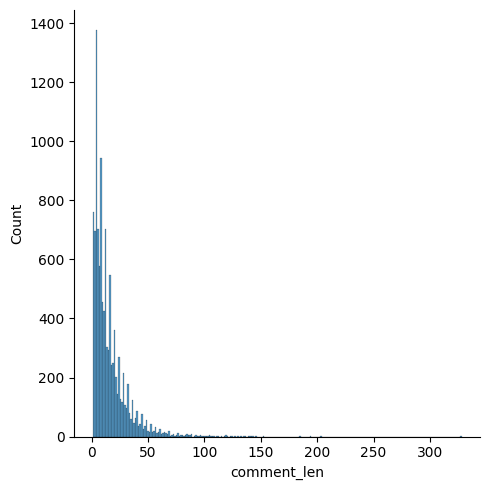

In [ ]:
# Visualize the length distribution 
sns.displot(data_promoter.comment_len, kde=False)

In [ ]:
#DATA PREPROCESSING STEPS
### Removing stopwords, tokenizing data, lemmaziting, converting to lower case, remove panctuations, i 

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt", "wasy", "grear",
                   "aving","nope", "goo","lol","nah","hiccup", "imani","like"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split('/')]))

    # correct typose
    # text_col = text_col.apply(lambda x: ' '.join([str(TextBlob(w).correct()) for w in x.split('/')]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: ' '.join(re.sub(re.compile("["
                                                                      u"\U00002700-\U000027BF"  # Dingbats
                                                                      u"\U0001F600-\U0001F64F"  # Emoticons
                                                                      u"\U00002600-\U000026FF"  # Miscellaneous Symbols
                                                                      u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
                                                                      u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                                                      u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                                                      u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                                                                       "]+", re.UNICODE), '', x).split()))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    # from nltk.stem import WordNetLemmatizer
    # nltk.download('wordnet')
    # nltk.download('omw-1.4')
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # stemming
    #from nltk.stem import PorterStemmer
    #text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [ ]:
# view one instance
data_promoter["comment"][3]

'My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well. '

In [ ]:
# Calling the data preprocessing function above and visualizing same instance as above
data_pro_clean = preprocess(data_promoter["comment"])  
data_pro_clean[3]

'agent informed help make process super easy painless got ended saving money well'

In [ ]:
##Quick check through the data we are using
data_pro_clean.head()

0                                       listen problem
2                             working fast easy result
3    agent informed help make process super easy pa...
4    got vehicle cut half amazing mrskrista helpful...
5    quick way find best price attempt upsale produ...
Name: comment, dtype: object

In [ ]:
## Total review data
# data_pro_clean_arr.shape

In [ ]:
# BERTopic actually requires data in an array format. We convert the data frame texts into a numpy array object.
data_pro_clean_arr = np.array(data_pro_clean)   
data_pro_clean_arr

array(['listen problem', 'working fast easy result',
       'agent informed help make process super easy painless got ended saving money well',
       ...,
       'better rate anyone great customer service friendly knowledgeable staff',
       'everyone worked professional answered question helped navigate choice overall made process simple fast',
       'great overall experience easy getting even though changed provider initial underwriting not sometimes confusing working multiple rep'],
      dtype=object)

In [ ]:
data_pro_clean_arr.shape

(11251,)

## Modelling with BERTOPIC

### Hyper-parameter tuning

In [ ]:
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = embedding_model.encode(data_pro_clean_arr)
print(embeddings.shape)

(11251, 384)


In [ ]:
umap_n_neighbors_ls = [30, 35]
umap_n_components_ls = [15, 20]

# hdbscan_cluster_size_ls = [20, 30]
# hdbscan_metric_ls = ["euclidean"]
# hdbscan_mins_samples = [3,5,10]

num_topics_ls = [6,7,8,9]

all_hyper_params_ls = list(itertools.product(umap_n_neighbors_ls,umap_n_components_ls, num_topics_ls))

In [ ]:
len(all_hyper_params_ls)

16

In [ ]:
# create embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(data_pro_clean_arr)

In [ ]:
coherence_all_ls = []
umap_n_neighbors_all_ls = []
umap_n_components_all_ls = []
hdbscan_min_samples_all_ls = []
num_topics_all_ls = []


for param in all_hyper_params_ls:

  print("[Running for UMAP n_neighbors:{}, UMAP n_components:{}, num_topics:{}]".format(param[0], param[1], param[2]))

  ## Defining the different steps the Bertopic algorithm uses to process and analyse the data

  # Step 2 - Reduce dimensionality
  umap_model = UMAP(n_neighbors=param[0], n_components=param[1], min_dist=0.1, metric='cosine', random_state=2) # n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'

  # Step 3 - Cluster reduced embeddings
  hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples = 3, cluster_selection_method='eom', prediction_data=True) # min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', 

  # Step 4 - Tokenize topics and create ngrams
  vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range= (2, 5))

  # Step 5 - Create topic representation 
  ctfidf_model = ClassTfidfTransformer()

  # Step 6 - (Optional) Fine-tune topic representations with 
  # a `bertopic.representation` model
  # representation_model = KeyBERTInspired()

  # Putting All steps together nr_topics=7
  topic_model = BERTopic(nr_topics= param[2],
                          embedding_model=embedding_model,    # Step 1 - Extract embeddings
                          umap_model=umap_model,              # Step 2 - Reduce dimensionality
                          hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
                          vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
                          ctfidf_model=ctfidf_model, verbose = True, # Step 5 - Extract topic words
                          # representation_model=representation_model
                         top_n_words = 20
                         )          
                          #diversity=0.8)                       # Step 6 - Diversify topic words)

  topics, probs = topic_model.fit_transform(data_pro_clean_arr, embeddings)

  display(topic_model.visualize_topics())


  display(topic_model.visualize_barchart(top_n_topics=10, n_words =10, width = 400, height = 500))


  documents = pd.DataFrame({"Document": data_pro_clean_arr,
                          "ID": range(len(data_pro_clean_arr)),
                          "Topic": topics})
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
  cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = topic_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                for topic in range(len(set(topics))-1)]

  # Removing any empty strings
  topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]
  topic_words


  # Evaluate
  coherence_model = CoherenceModel(topics=topic_words, 
                                  texts=tokens, 
                                  corpus=corpus,
                                  dictionary=dictionary, 
                                  coherence='c_v')
  coherence = coherence_model.get_coherence()
  print("Coherence score with {} topics: {}".format(param[2], coherence))

  coherence_all_ls.append(coherence)
  umap_n_neighbors_all_ls.append(param[0])
  umap_n_components_all_ls.append(param[1])
  # hdbscan_min_samples_all_ls.append(param[2])
  num_topics_all_ls.append(param[2])


[Running for UMAP n_neighbors:30, UMAP n_components:15, num_topics:6]


2023-03-29 04:09:39,404 - BERTopic - Reduced dimensionality
2023-03-29 04:09:40,507 - BERTopic - Clustered reduced embeddings
2023-03-29 04:09:52,226 - BERTopic - Reduced number of topics from 87 to 6


Coherence score with 6 topics: 0.6212227635203108
[Running for UMAP n_neighbors:30, UMAP n_components:15, num_topics:7]


2023-03-29 04:10:36,015 - BERTopic - Reduced dimensionality
2023-03-29 04:10:37,113 - BERTopic - Clustered reduced embeddings
2023-03-29 04:10:49,177 - BERTopic - Reduced number of topics from 87 to 7


Coherence score with 7 topics: 0.5969564458140416
[Running for UMAP n_neighbors:30, UMAP n_components:15, num_topics:8]


2023-03-29 04:11:31,159 - BERTopic - Reduced dimensionality
2023-03-29 04:11:32,276 - BERTopic - Clustered reduced embeddings
2023-03-29 04:11:44,215 - BERTopic - Reduced number of topics from 87 to 8


Coherence score with 8 topics: 0.6091159640576249
[Running for UMAP n_neighbors:30, UMAP n_components:15, num_topics:9]


2023-03-29 04:12:25,520 - BERTopic - Reduced dimensionality
2023-03-29 04:12:27,352 - BERTopic - Clustered reduced embeddings
2023-03-29 04:12:36,772 - BERTopic - Reduced number of topics from 87 to 9


Coherence score with 9 topics: 0.594835845475399
[Running for UMAP n_neighbors:30, UMAP n_components:20, num_topics:6]


2023-03-29 04:13:24,986 - BERTopic - Reduced dimensionality
2023-03-29 04:13:26,493 - BERTopic - Clustered reduced embeddings
2023-03-29 04:13:37,901 - BERTopic - Reduced number of topics from 83 to 6


Coherence score with 6 topics: 0.6065825230960464
[Running for UMAP n_neighbors:30, UMAP n_components:20, num_topics:7]


2023-03-29 04:14:23,915 - BERTopic - Reduced dimensionality
2023-03-29 04:14:25,454 - BERTopic - Clustered reduced embeddings
2023-03-29 04:14:37,306 - BERTopic - Reduced number of topics from 83 to 7


Coherence score with 7 topics: 0.6109822210462296
[Running for UMAP n_neighbors:30, UMAP n_components:20, num_topics:8]


2023-03-29 04:15:22,665 - BERTopic - Reduced dimensionality
2023-03-29 04:15:24,181 - BERTopic - Clustered reduced embeddings
2023-03-29 04:15:35,688 - BERTopic - Reduced number of topics from 83 to 8


Coherence score with 8 topics: 0.6011820879880505
[Running for UMAP n_neighbors:30, UMAP n_components:20, num_topics:9]


2023-03-29 04:16:21,253 - BERTopic - Reduced dimensionality
2023-03-29 04:16:23,328 - BERTopic - Clustered reduced embeddings
2023-03-29 04:16:33,482 - BERTopic - Reduced number of topics from 83 to 9


Coherence score with 9 topics: 0.6164975473025458
[Running for UMAP n_neighbors:35, UMAP n_components:15, num_topics:6]


2023-03-29 04:17:21,804 - BERTopic - Reduced dimensionality
2023-03-29 04:17:22,913 - BERTopic - Clustered reduced embeddings
2023-03-29 04:17:32,208 - BERTopic - Reduced number of topics from 83 to 6


Coherence score with 6 topics: 0.5010656496548419
[Running for UMAP n_neighbors:35, UMAP n_components:15, num_topics:7]


2023-03-29 04:18:16,556 - BERTopic - Reduced dimensionality
2023-03-29 04:18:17,929 - BERTopic - Clustered reduced embeddings
2023-03-29 04:18:27,117 - BERTopic - Reduced number of topics from 83 to 7


Coherence score with 7 topics: 0.5435533815700911
[Running for UMAP n_neighbors:35, UMAP n_components:15, num_topics:8]


2023-03-29 04:19:11,884 - BERTopic - Reduced dimensionality
2023-03-29 04:19:13,431 - BERTopic - Clustered reduced embeddings
2023-03-29 04:19:23,977 - BERTopic - Reduced number of topics from 83 to 8


Coherence score with 8 topics: 0.5204024957482526
[Running for UMAP n_neighbors:35, UMAP n_components:15, num_topics:9]


2023-03-29 04:20:07,355 - BERTopic - Reduced dimensionality
2023-03-29 04:20:08,410 - BERTopic - Clustered reduced embeddings
2023-03-29 04:20:19,899 - BERTopic - Reduced number of topics from 83 to 9


Coherence score with 9 topics: 0.5221051054284954
[Running for UMAP n_neighbors:35, UMAP n_components:20, num_topics:6]


2023-03-29 04:21:09,064 - BERTopic - Reduced dimensionality
2023-03-29 04:21:10,756 - BERTopic - Clustered reduced embeddings
2023-03-29 04:21:24,736 - BERTopic - Reduced number of topics from 86 to 6


Coherence score with 6 topics: 0.6315024634084102
[Running for UMAP n_neighbors:35, UMAP n_components:20, num_topics:7]


2023-03-29 04:22:12,349 - BERTopic - Reduced dimensionality
2023-03-29 04:22:14,743 - BERTopic - Clustered reduced embeddings
2023-03-29 04:22:24,750 - BERTopic - Reduced number of topics from 86 to 7


Coherence score with 7 topics: 0.655892791271829
[Running for UMAP n_neighbors:35, UMAP n_components:20, num_topics:8]


2023-03-29 04:23:14,385 - BERTopic - Reduced dimensionality
2023-03-29 04:23:16,247 - BERTopic - Clustered reduced embeddings
2023-03-29 04:23:28,174 - BERTopic - Reduced number of topics from 86 to 8


Coherence score with 8 topics: 0.6422642585506051
[Running for UMAP n_neighbors:35, UMAP n_components:20, num_topics:9]


2023-03-29 04:24:16,318 - BERTopic - Reduced dimensionality
2023-03-29 04:24:17,947 - BERTopic - Clustered reduced embeddings
2023-03-29 04:24:30,091 - BERTopic - Reduced number of topics from 86 to 9


Coherence score with 9 topics: 0.6304496076511734


In [ ]:
params_dict = {"Coherence Score":coherence_all_ls, "UMAP_n_neighbors":umap_n_neighbors_all_ls, "UMAP_n_components":umap_n_components_all_ls,  "Number of topics":num_topics_all_ls}
df_params = pd.DataFrame(params_dict)
display(df_params.sort_values(by='Coherence Score', ascending=False))

,Coherence Score,UMAP_n_neighbors,UMAP_n_components,Number of topics
13,0.655893,35,20,7
14,0.642264,35,20,8
12,0.631502,35,20,6
15,0.630450,35,20,9
0,0.621223,30,15,6
7,0.616498,30,20,9
5,0.610982,30,20,7
2,0.609116,30,15,8
4,0.606583,30,20,6
6,0.601182,30,20,8


### Fitting BERT

In [ ]:
## Defining the different steps the Bertopic algorithm uses to process and analyse the data
# [Running for UMAP n_neighbors:30, UMAP n_components:20, num_topics:8]
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=30, n_components=20, min_dist=0.1, metric='cosine', random_state=2) # n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples = 3, metric="euclidean", cluster_selection_method='eom', prediction_data=True) # min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', 

# Step 4 - Tokenize topics and create ngrams
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range= (2, 5))

# Step 5 - Create topic representation 
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# Putting All steps together
topic_model1 = BERTopic(nr_topics= 8,
                        embedding_model=embedding_model,    # Step 1 - Extract embeddings
                        umap_model=umap_model,              # Step 2 - Reduce dimensionality
                        hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
                        vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
                        ctfidf_model=ctfidf_model, verbose = True, # Step 5 - Extract topic words
                        # representation_model=representation_model
                        top_n_words = 20,
                        calculate_probabilities = True
                        )          
                        #diversity=0.8)                       # Step 6 - Diversify topic words)

topics, probs = topic_model1.fit_transform(data_pro_clean_arr, embeddings)

display(topic_model1.visualize_topics())


display(topic_model1.visualize_barchart(top_n_topics=10, n_words =10, width = 400, height = 500))



documents = pd.DataFrame({"Document": data_pro_clean_arr,
                        "ID": range(len(data_pro_clean_arr)),
                        "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
cleaned_docs = topic_model1._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model1.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model1.get_topic(topic)] 
              for topic in range(len(set(topics))-1)]

# Removing any empty strings
topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]
topic_words


# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                texts=tokens, 
                                corpus=corpus,
                                dictionary=dictionary, 
                                coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence score with 8 topics: {}".format(coherence))

2023-03-29 22:18:27,137 - BERTopic - Reduced dimensionality
2023-03-29 22:18:35,528 - BERTopic - Clustered reduced embeddings
2023-03-29 22:18:52,277 - BERTopic - Reduced number of topics from 83 to 8


Coherence score with 8 topics: 0.6011820879880505


In [ ]:
pd.set_option('display.max_colwidth', 0)
df_scored = pd.DataFrame({"Topic":topics, "Document":data_pro_clean_arr, "Document_raw":data_promoter["comment"]}).reset_index().drop(columns="index")
df_scored["Topic"].value_counts()

 0    4341
-1    3525
 1    2643
 2    291 
 3    236 
 4    106 
 5    56  
 6    53  
Name: Topic, dtype: int64

In [ ]:
# topic_model1.save("ft_model_3")

/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
topic_model1.visualize_documents(data_pro_clean_arr, hide_document_hover=True, hide_annotations=True)

In [ ]:
# Reduce outliers using the `distributions` strategy
new_topics = topic_model1.reduce_outliers(data_pro_clean_arr, topics, probabilities=probs, strategy="probabilities", threshold = 0.05)

# topic_model1.update_topics(data_pro_clean_arr, topics=new_topics)

topic_model1.visualize_documents(data_pro_clean_arr,hide_document_hover=True, hide_annotations=True)


In [ ]:
display(topic_model1.visualize_topics())

display(topic_model1.visualize_barchart(top_n_topics=10, n_words =10, width = 400, height = 500))

In [ ]:
pd.set_option('display.max_colwidth', 0)
df_scored = pd.DataFrame({"Topic":new_topics, "Document":data_pro_clean_arr, "Document_raw":data_promoter["comment"]}).reset_index().drop(columns="index")
df_scored["Topic"].value_counts()

 0    7011
 1    3299
 2    291 
 3    236 
-1    199 
 4    106 
 5    56  
 6    53  
Name: Topic, dtype: int64

### Scoring



In [ ]:
# df_scored.to_csv("df_scored_outlier_reduced.csv")

In [ ]:
df_scored

,Topic,Document,Document_raw
0,0,listen problem,Listen to problems
1,1,working fast easy result,Working with you was fast and easy and I like the result.
2,0,agent informed help make process super easy painless got ended saving money well,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.
3,0,got vehicle cut half amazing mrskrista helpful listened everything wanted vehicle recommend company anyone,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!"
4,-1,quick way find best price attempt upsale product product offered matched existing policy term apple apple not get bombarded hounded salesperson,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople."
...,...,...,...
11246,0,quickly response appropriate information,Quickly response with appropriate information
11247,1,easy friendly process,very easy and friendly process!
11248,0,better rate anyone great customer service friendly knowledgeable staff,Better rate than anyone. Great customer service. Friendly and knowledgeable staff.
11249,0,everyone worked professional answered question helped navigate choice overall made process simple fast,"Everyone I worked with was very professional, answered my questions and helped me navigate my choices and overall made the process very simple and fast."


In [ ]:
df_scored2 = topic_model1.get_document_info(data_pro_clean_arr) 
df_scored2

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,listen problem,-1,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.792780,False
1,working fast easy result,1,1_easy process_process easy_easy easy_quick easy,easy process - process easy - easy easy - quick easy - fast easy - easy work - made process - easy process easy - super easy - easy fast - easy quick - process simple - process quick - whole process - simple easy - smooth process - great rate - best rate - easy convenient - rate easy,1.000000,False
2,agent informed help make process super easy painless got ended saving money well,0,0_customer service_great service_great customer_great customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,1.000000,False
3,got vehicle cut half amazing mrskrista helpful listened everything wanted vehicle recommend company anyone,-1,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.249996,False
4,quick way find best price attempt upsale product product offered matched existing policy term apple apple not get bombarded hounded salesperson,-1,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.931518,False
...,...,...,...,...,...,...
11246,quickly response appropriate information,0,0_customer service_great service_great customer_great customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,1.000000,False
11247,easy friendly process,-1,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.308705,False
11248,better rate anyone great customer service friendly knowledgeable staff,0,0_customer service_great service_great customer_great customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,0.417498,False
11249,everyone worked professional answered question helped naviga

In [ ]:
df_scored2["Topic"].value_counts()

 0    4341
-1    3525
 1    2643
 2    291 
 3    236 
 4    106 
 5    56  
 6    53  
Name: Topic, dtype: int64

In [ ]:
df_scored.drop(columns = ["Document"], inplace=True)
df_scored2.drop(columns = ["Topic"], inplace=True)
df_merge = pd.concat([df_scored, df_scored2], axis=1)
# pd.merge(df_scored, df_scored2, how="left", on = "Document")
df_merge

,Topic,Document_raw,Document,Name,Top_n_words,Probability,Representative_document
0,0,Listen to problems,listen problem,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.792780,False
1,1,Working with you was fast and easy and I like the result.,working fast easy result,1_easy process_process easy_easy easy_quick easy,easy process - process easy - easy easy - quick easy - fast easy - easy work - made process - easy process easy - super easy - easy fast - easy quick - process simple - process quick - whole process - simple easy - smooth process - great rate - best rate - easy convenient - rate easy,1.000000,False
2,0,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.,agent informed help make process super easy painless got ended saving money well,0_customer service_great service_great customer_great customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,1.000000,False
3,0,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!",got vehicle cut half amazing mrskrista helpful listened everything wanted vehicle recommend company anyone,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.249996,False
4,-1,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople.",quick way find best price attempt upsale product product offered matched existing policy term apple apple not get bombarded hounded salesperson,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,0.931518,False
...,...,...,...,...,...,...,...
11246,0,Quickly response with appropriate information,quickly response appropriate information,0_customer service_great service_great customer_great customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,1.000000,False
11247,1,very easy and friendly process!,easy friendly process,-1_customer service_process easy_easy process_whole process,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - grea

In [ ]:
df_merge["Topic"].value_counts()

 0    7011
 1    3299
 2    291 
 3    236 
-1    199 
 4    106 
 5    56  
 6    53  
Name: Topic, dtype: int64

In [ ]:
comment_arr = np.array(data_promoter["comment"])
year_arr = np.array(data_promoter["year"])

# Generating a data frame of topics over time
topics_over_time = topic_model1.topics_over_time(comment_arr, year_arr, global_tuning=True,evolution_tuning=True) # global_tuning=True,evolution_tuning=True 
topics_over_time

6it [00:14,  2.44s/it]


,Topic,Words,Frequency,Timestamp
0,-1,"customer service, easy process, process easy, every step, step way",157,2017
1,0,"customer service, great service, great customer, great customer service, great experience",188,2017
2,1,"easy process, process easy, easy easy, easy work, made easy",106,2017
3,2,"responsive customer service easy, helpful responsive, responsive customer, responsive customer service, customer service easy",16,2017
4,3,"coverage price, got twice coverage, coverage great support, easy got twice, price old life",9,2017
5,4,"nicely kept informed, needed take, went nicely kept informed step, went nicely kept informed, went nicely kept",4,2017
6,5,"pod save america, pod save, save america, everyone patient website convenient easy, found listening pod",4,2017
7,6,"seamless process great communciation, great communciation, process great communciation, seamless process great, seamless process",1,2017
8,-1,"customer service, process easy, made process, easy process, super easy",342,2018
9,0,"customer service, great service, great customer, great customer service, service great",429,2018


In [ ]:
topics_over_time = topics_over_time.loc[topics_over_time["Topic"]!=-1].copy()
topics_over_time["Total_by_year"] = topics_over_time.groupby('Timestamp')['Frequency'].transform('sum')
topics_over_time["Prop_Topic_by_year"] = topics_over_time["Frequency"]/topics_over_time["Total_by_year"]
# topics_over_time['Prop_Topic_by_year'] = topics_over_time['Prop_Topic_by_year'].map('{:.2%}'.format)
# topics_over_time['Prop_Topic_by_year'] = topics_over_time['Prop_Topic_by_year'].apply(lambda x: '{:.2%}'.format(x)).astype(float)
topics_over_time

,Topic,Words,Frequency,Timestamp,Total_by_year,Prop_Topic_by_year
1,0,"customer service, great service, great customer, great customer service, great experience",188,2017,328,0.573171
2,1,"easy process, process easy, easy easy, easy work, made easy",106,2017,328,0.323171
3,2,"responsive customer service easy, helpful responsive, responsive customer, responsive customer service, customer service easy",16,2017,328,0.048780
4,3,"coverage price, got twice coverage, coverage great support, easy got twice, price old life",9,2017,328,0.027439
5,4,"nicely kept informed, needed take, went nicely kept informed step, went nicely kept informed, went nicely kept",4,2017,328,0.012195
6,5,"pod save america, pod save, save america, everyone patient website convenient easy, found listening pod",4,2017,328,0.012195
7,6,"seamless process great communciation, great communciation, process great communciation, seamless process great, seamless process",1,2017,328,0.003049
9,0,"customer service, great service, great customer, great customer service, service great",429,2018,761,0.563732
10,1,"easy process, process easy, easy easy, quick easy, easy process easy",253,2018,761,0.332457
11,2,"friendly responsive, responsive customer, service responsiveness, customer service, easy responsive",41,2018,761,0.053876


<Axes: xlabel='Timestamp', ylabel='Prop_Topic_by_year'>

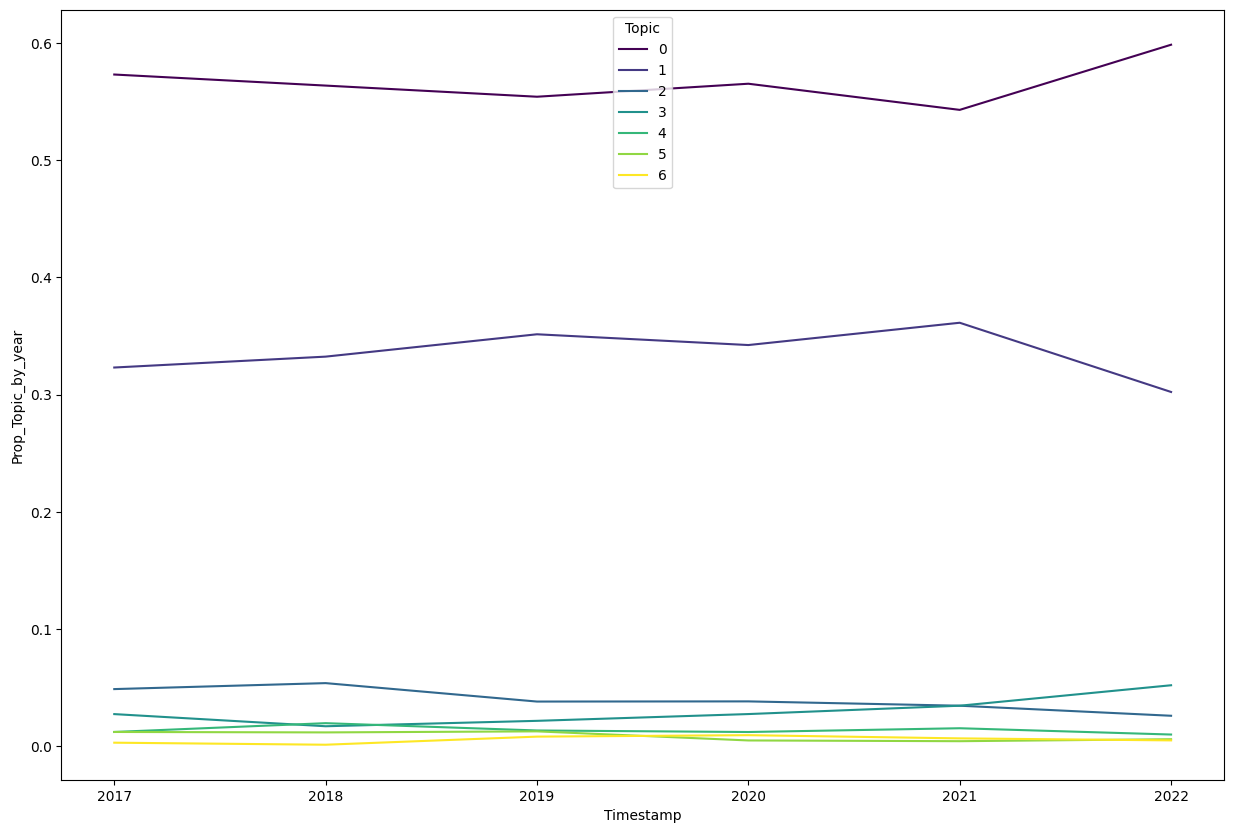

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
sns.lineplot(
    data=topics_over_time, x="Timestamp", y="Prop_Topic_by_year", hue="Topic", palette = "viridis"
    #  err_style="bars", errorbar=("se", 2),
)

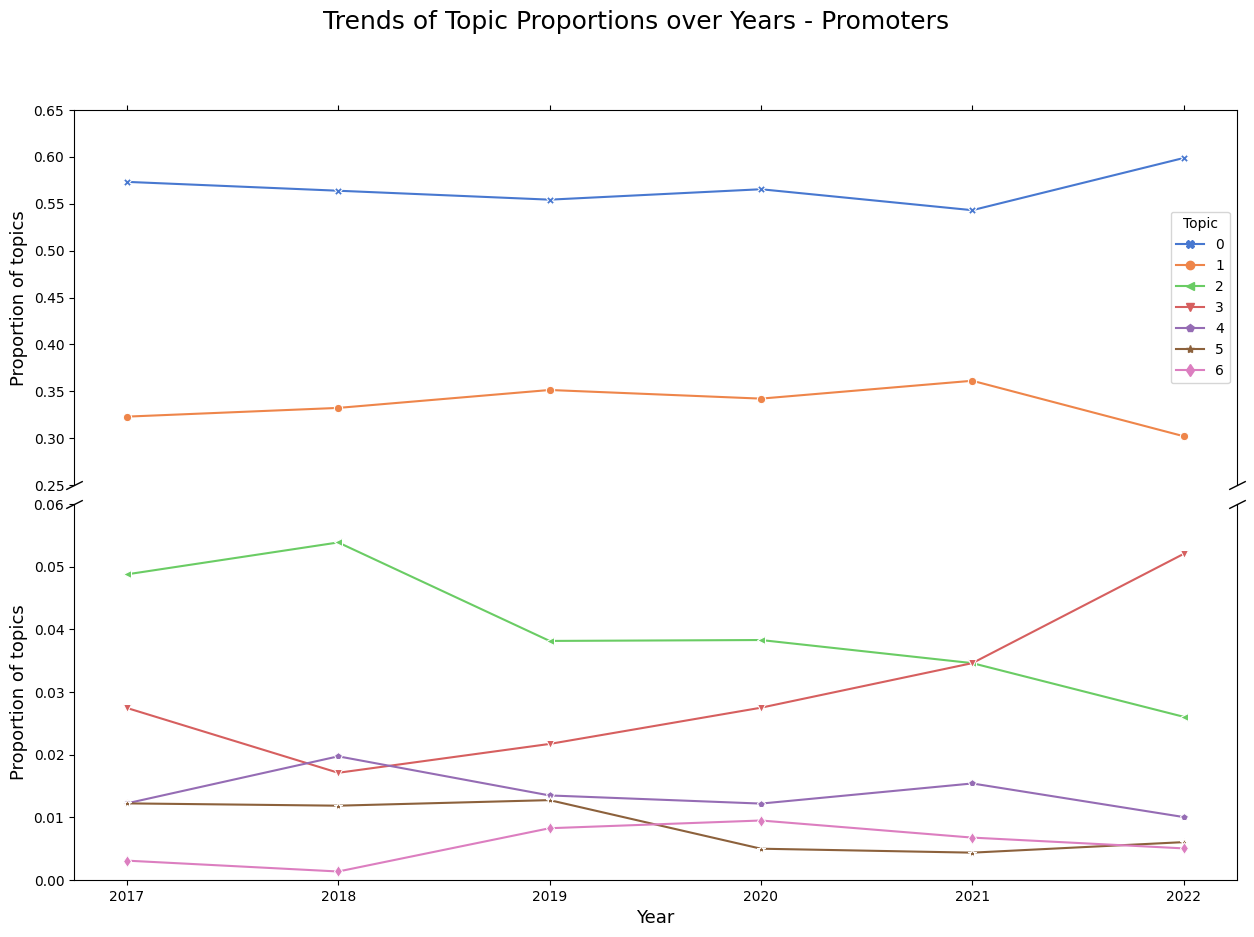

In [ ]:
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax1) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,10))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# sns.color_palette("Spectral", as_cmap=True)

# plot the same data on both axes
sns.lineplot(
    data=topics_over_time, x="Timestamp", y="Prop_Topic_by_year", hue="Topic", 
    palette = "muted", 
    ax=ax1, style = "Topic", dashes=False, 
    #  err_style="bars", errorbar=("se", 2),
    markers= ["X", "o","<", "v","p","*","d"],
)

# ax1.legend(labels=["Topic 0: Excellent customer service",
#     "Topic 1: Quick and easy process",
#     "Topic 2: Responsive CSRs",
#     "Topic 3: Good coverage",
#     "Topic 4: Guidance available",
#     "Topic 5: Recommended by podcasts/radio",
#     "Topic 6: Seamless experience"])

# sns.color_palette("icefire", as_cmap=True)
sns.lineplot(
    data=topics_over_time, x="Timestamp", y="Prop_Topic_by_year", hue="Topic", 
    palette = "muted", 
    ax=ax2, style = "Topic", dashes=False,
    #  err_style="bars", errorbar=("se", 2),
    markers= ["X", "o","<", "v","p","*","d"],
)

plt.xlabel("Year", fontsize = 13)
ax1.set_ylabel('Proportion of topics', fontsize = 13)
ax2.set_ylabel('Proportion of topics', fontsize = 13)
# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.25, 0.65)  # outliers only
ax2.set_ylim(0.00, .06)  # most of the data

# labels = [item.get_text() for item in ax2.get_xticklabels()]
# ax2.set_xticklabels([str(round(float(label), 2)) for label in labels])

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.get_legend().remove()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.suptitle("Trends of Topic Proportions over Years - Promoters", fontsize = 18)

plt.show()

### Creating output

In [ ]:
df_left = df_scored
df_right = df_scored2[["Top_n_words"]]

df_merge = pd.concat([df_left, df_right], axis=1)
df_merge.head()

,Topic,Document_raw,Top_n_words
0,0,Listen to problems,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed
1,1,Working with you was fast and easy and I like the result.,easy process - process easy - easy easy - quick easy - fast easy - easy work - made process - easy process easy - super easy - easy fast - easy quick - process simple - process quick - whole process - simple easy - smooth process - great rate - best rate - easy convenient - rate easy
2,0,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service
3,0,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!",customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed
4,-1,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople.",customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed


In [ ]:
data_promoter2 = data_promoter.copy()
data_promoter2.reset_index(inplace = True)

df_merge2 = pd.concat([data_promoter2[["comment","response_timestamp", "score_categorized"]], df_merge], axis=1)
df_merge2.head()

,comment,response_timestamp,score_categorized,Topic,Document_raw,Top_n_words
0,Listen to problems,2021-10-04 14:04:10+00:00,promoter,0,Listen to problems,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed
1,Working with you was fast and easy and I like the result.,2021-04-02 16:57:16+00:00,promoter,1,Working with you was fast and easy and I like the result.,easy process - process easy - easy easy - quick easy - fast easy - easy work - made process - easy process easy - super easy - easy fast - easy quick - process simple - process quick - whole process - simple easy - smooth process - great rate - best rate - easy convenient - rate easy
2,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.,2022-01-06 13:03:58+00:00,promoter,0,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service
3,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!",2022-02-17 11:47:16+00:00,promoter,0,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!",customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed
4,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople.",2021-02-03 13:32:07+00:00,promoter,-1,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople.",customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed


In [ ]:
df_merge2["Topic"].value_counts()

 0    7011
 1    3299
 2    291 
 3    236 
-1    199 
 4    106 
 5    56  
 6    53  
Name: Topic, dtype: int64

In [ ]:
df_merge2["topic_desc"] = df_merge2["Topic"].map(topic_desc_dict)

rename_dict = {
    "response_timestamp":"date",
    "score_categorized" : "group",
    "Topic":"topic",
    "Top_n_words":"top_n_words",
}

df_merge2.rename(columns = rename_dict, inplace=True)

df_merge2["topic_desc_new"] = np.where(df_merge2["topic"]==-1,df_merge2["topic_desc"],df_merge2["topic"].astype(str) + " - " + df_merge2["topic_desc"])
df_merge2.drop("topic_desc", axis = 1, inplace = True)
df_merge2.rename(columns = {"topic_desc_new":"topic_desc"}, inplace=True)

df_merge2 = df_merge2[['comment', 'group', 'topic', 'topic_desc', 'top_n_words', 'date']]

df_merge2.head()

,comment,group,topic,topic_desc,top_n_words,date
0,Listen to problems,promoter,0,0 - Excellent customer service,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,2021-10-04 14:04:10+00:00
1,Working with you was fast and easy and I like the result.,promoter,1,1 - Quick and easy process,easy process - process easy - easy easy - quick easy - fast easy - easy work - made process - easy process easy - super easy - easy fast - easy quick - process simple - process quick - whole process - simple easy - smooth process - great rate - best rate - easy convenient - rate easy,2021-04-02 16:57:16+00:00
2,My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well.,promoter,0,0 - Excellent customer service,customer service - great service - great customer - great customer service - service great - service easy - great experience - great communication - easy process - process easy - excellent customer - service good - excellent customer service - easy work - excellent service - easy great - customer service great - good communication - process great - good service,2022-01-06 13:03:58+00:00
3,"I got my insurance for both vehicles cut in half, which is amazing!! And Mrs.Krista was very helpful and listened to everything I wanted for my vehicles; I will definitely recommend this company to anyone!! 10/10!",promoter,0,0 - Excellent customer service,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,2022-02-17 11:47:16+00:00
4,"It was a quick way to find the best prices for insurance. There were no attempts to upsale products, products offered matched existing policies terms - ""apples to apples"". I didn't get bombarded or hounded by salespeople.",promoter,-1,Outlier,customer service - process easy - easy process - whole process - easy work - answered question - every step - great customer - made process - great customer service - great service - answer question - entire process - throughout process - start finish - super easy - made easy - step way - quick response - kept informed,2021-02-03 13:32:07+00:00


In [ ]:
# df_merge2.to_csv("data_promoters.csv")